<div align="center">
  <h1> 2 - Data Preparation </h1> <a name="0-bullet"></a>
</div>

- [1. Setup](#1-bullet)
    * [1.1 Set the working directory](#11-bullet)
    * [1.2 Load the data](#12-bullet)
- [2. Clean the DataFrame object](#2-bullet)
    * [2.1 Change data types](#21-bullet)
    * [2.2 Replace empty strings and lists with NaN](#22-bullet)
- [3. Missing data visualization](#3-bullet)
- [4. Define helper functions](#4-bullet)
    * [4.1 Splitting lyrics into words and verses](#41-bullet)
- [5. Filter the data](#5-bullet)
    * [5.1 Remove rows with unreleased or empty lyrics](#51-bullet)
    * [5.2 Remove rows with no Eminem's verses](#52-bullet)
    * [5.3 Remove rows with non-english lyrics](#53-bullet)
    * [5.4 Remove rows with unfinished and non-valid lyrics](#54-bullet)
    * [5.5 Remove rows with the excluded terms in the title ](#55-bullet)
    * [5.6 Removing rows with non-valid data found during the analysis](#56-bullet)
    * [5.7 The dataset after filtering](#57-bullet)
- [6. Contractions and dash/hyphen words analysis](#6-bullet)
    * [6.1 Contractions](#61-bullet)
    * [6.2 Dash/hyphen words](#62-bullet)
- [7. Store the dataset after processing](#7-bullet)

The same data preparation can be done for each dataset in the project - the dataset that has only Eminem's song data or the dataset that includes his non-song data as well (like skits, snippets, interviews, etc.).

---

You may have to install:
> `!pip install missingno` <br>
> `!pip install pickle5`

In [9]:
import os
import re
import json
import string

import numpy as np
import pandas as pd
import missingno as msno
import pickle5 as pickle

from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

---

# 1. Setup <a name="1-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>


## 1.1 Set the working directory <a name="11-bullet"></a>

In [4]:
ROOT_DIR = "./eminem-lyrics-generator/notebooks/" 
IN_GOOGLE_COLAB = True

if IN_GOOGLE_COLAB:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')

    # change the current working directory
    %cd gdrive/'My Drive'

    # create a root directory if there's none
    if not os.path.isdir(ROOT_DIR):
        %mkdir $ROOT_DIR

    # change the current working directory
    %cd $ROOT_DIR

Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/eminem-lyrics-generator/notebooks


In [5]:
# specifies paths to all files in the project
SETTINGS_FILE_PATH = os.path.join(os.path.abspath(".."), 'SETTINGS.json')
settings = json.load(open(SETTINGS_FILE_PATH))

## 1.2 Load the data <a name="12-bullet"></a> 

In [10]:
EMINEM_DF_DIR = settings['EMINEM_DF_ALL_RAW_PATH']                  # or 'EMINEM_DF_SONGS_CLEAN_PATH'

with open(EMINEM_DF_DIR, 'rb') as f:
    data_df = pickle.load(f)

data_df.head()

,song_id,state,title,artist,featured,popularity,album_id,album_name,release_date,lyrics,url,comments,comments_total_count
0,235729,complete,Rap God,Eminem,[],1,672689.0,The Marshall Mathers LP2 (Deluxe),2013-10-14,"[Intro]\n""Look, I was gonna go easy on you not...",https://genius.com/Eminem-rap-god-lyrics,[It’s clear now to everyone who the King and t...,459
1,3958196,complete,Killshot,Eminem,[],2,NaN,None,2018-09-14,"[Intro]\nYou sound like a bitch, bitch\nShut t...",https://genius.com/Eminem-killshot-lyrics,"[Eminem Sucks haha, GENIUS NOT EVEN READY LOL,...",1252
2,5180439,complete,Godzilla,Eminem,[Juice WRLD],3,594809.0,Music to Be Murdered By,2020-01-17,"[Intro]\nUgh, you're a monster\n\n[Verse 1: Em...",https://genius.com/Eminem-godzilla-lyrics,[This definitely takes the spot of most unexpe...,624
3,207,complete,Lose Yourself,Eminem,[],4,452012.0,The Singles,2002-10-28,"[Intro]\nLook, if you had one shot or one oppo...",https://genius.com/Eminem-lose-yourself-lyrics,[This was Eminem at the top of the entire rap ...,265
4,235732,complete,The Monster,Eminem,[Rihanna],5,672689.0,The Marshall Mathers LP2 (Deluxe),2013-10-29,[Intro: Rihanna]\nI'm friends with the monster...,https://genius.com/Eminem-the-monster-lyrics,[Why do people hate that Eminem is different n...,171


# 2. Clean the DataFrame object <a name="2-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

## 2.1 Change data types <a name="21-bullet"></a>

In [ ]:
data_df['release_date'] = pd.to_datetime(data_df['release_date'], errors='raise')
data_df = data_df.astype({"song_id": np.uint32, 
                          "state": "category", 
                          "lyrics": "string",
                          "popularity": np.uint16, 
                          "album_id": "Int32", 
                          "comments_total_count": np.uint16})

In [ ]:
data_df.dtypes

song_id                         uint32
state                         category
title                           object
artist                          object
featured                        object
popularity                      uint16
album_id                         Int32
album_name                      object
release_date            datetime64[ns]
lyrics                          string
url                             object
comments                        object
comments_total_count            uint16
dtype: object

## 2.2 Replace empty strings and lists with NaN <a name="22-bullet"></a>

In [ ]:
data_df = data_df.replace('', np.nan)
data_df['featured'] = data_df['featured'].apply(lambda featured: None if featured==list() else featured)
data_df['comments'] = data_df['comments'].apply(lambda comments: None if comments==list() else comments)

# 3. Missing data visualization (songs sorted by popularity) <a name="3-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

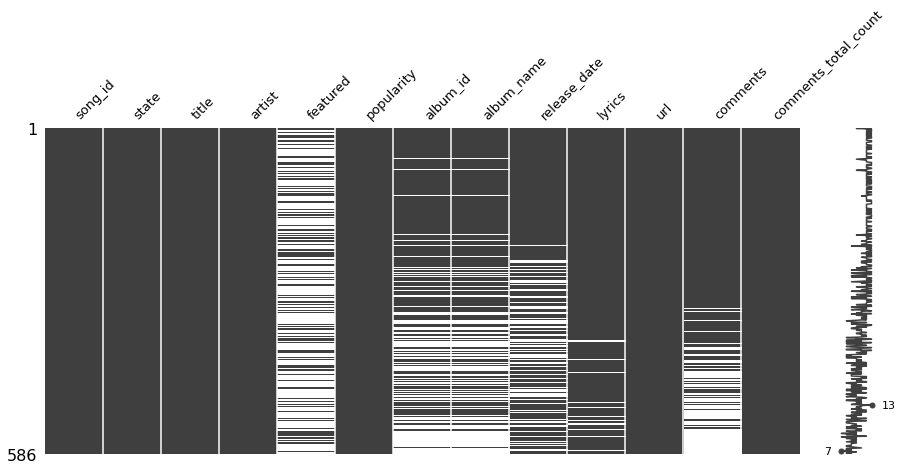

In [ ]:
msno.matrix(data_df.sort_values('popularity', ascending=True), 
            figsize=(15,6), 
            fontsize=13)
plt.show()

# 4. Define helper functions <a name="4-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

## 4.1 Splitting lyrics into words and verses <a name="41-bullet"></a>

In [ ]:
def split_lyrics_into_words(lyrics: str) -> list:
    """Splits lyrics into words. Does not clean contractions or dash words."""

    # remove section headers
    step1 = re.sub("\[.*\]\n", " ", lyrics.lower())           
    # remove all characters except letters, single quotation marks and dashes
    step2 = re.sub("[^a-z\'-]", " ", step1)             # or [^a-zA-z0-9]
    # replace consecutive identical quotations and dashes with only one character
    step3 = re.sub(r"([\'-]|\s)\1{2,}", r"\1", step2)
    # filter consecutive white spaces
    step4 = re.sub(r"\s{2,}", r" ", step3).strip()
    # reduce multiple consecutive identical letters into only two letters 
    step5 = re.sub(r"([a-z])\1{2,}", r"\1\1", step4)

    return step5.split(' ')

In [ ]:
SPECIAL_CASES = ['Book of Rhymes', 'Just the Two of Us']

def get_only_eminems_verses(row: pd.core.series.Series) -> str:
    "Returns only Eminem's verses from the lyrics."

    assert({'title', 'featured', 'lyrics'}.issubset(row.keys()))

    # clean the section headers that end with double newline characters
    lyrics = re.sub("]\n\n", "]\n", row.lyrics)

    # songs with no features (with few exceptions)
    if row[['featured']].isnull().values or row['title'] in SPECIAL_CASES:
        return re.sub("\[.*\]\n", "", lyrics)
    
    # split lyrics into verses
    song_verses = lyrics.split('\n\n')

    em_verses = ""
    for verse in song_verses:
        # check if the verse has one of the Eminem's section headers
        if re.search("\[.*Eminem.*\]", verse) or \
           re.search("\[.*Slim Shady.*\]", verse) or \
           re.search("\[.*B-Rabbit.*\]", verse) or \
           re.search("\[.*M&M.*\]", verse):
            em_verses += re.sub("\[.*\]\n", "", verse) + '\n\n'

    return em_verses

# 5. Filter the data (pipeline) <a name="5-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

## 5.1 Remove rows with unreleased or empty lyrics <a name="51-bullet"></a>

In [ ]:
# find unreleased and empty lyrics
rows_idxs = data_df[(data_df['state'] == 'unreleased') | data_df['lyrics'].isna()].index
# drop the songs
data_df = data_df.drop(rows_idxs).reset_index(drop=True)

## 5.2 Remove rows with no Eminem's verse <a name="52-bullet"></a>

In [ ]:
# get only Eminem's verses from songs
em_verses = data_df.apply(get_only_eminems_verses, axis=1)

# show songs with no Eminem's verses
data_df[em_verses == ''][['title', 'featured', 'album_name']]

,title,featured,album_name
182,Cum on Everybody,[Dina Rae],The Slim Shady LP
210,Revival (Interlude),[Alice and the Glass Lake],Revival
221,’97 Bonnie & Clyde,[Hailie Jade],The Slim Shady LP
269,Bitch (Skit),[Zoe Winkler],The Slim Shady LP
273,Paul (Skit) [2009],[Paul Rosenberg],Relapse
283,Paul (Skit) [1999],[Paul Rosenberg],The Slim Shady LP
288,Paul Rosenberg (Skit) [2002],[Paul Rosenberg],The Eminem Show
299,8 Mile Background Music,[Rap Genius],None
311,Soap (Skit),"[Royce da 5'9"", Jeff Bass]",The Slim Shady LP
318,W.E.G.O. (Interlude),"[DJ Head, Proof]",Infinite


Some reasons why these songs are missing Eminem's verses:
- unfinished/incorrect lyrics, 
- corrupted section headers in lyrics, no annotation for Eminem's parts in the song,
- his other names/nicknames are used (like M&M, Shady, Slim, etc.) - this is corrected in the `get_only_eminems_verses` function, so that the function recognizes those cases as well,
- non-english lyrics,
- etc.

These songs are not very useful for the analysis (there is no way to extract Eminem's parts), and therefore are dropped from the dataset.

In [ ]:
# get indices
empty_verses_indices = data_df[em_verses==''][['title', 'featured', 'album_name']].index

# drop the rows
data_df = data_df.drop(empty_verses_indices)    \
                 .reset_index(drop=True)

## 5.3 Remove rows with non-english lyrics <a name="53-bullet"></a>

In [ ]:
# control characters - include ascii characters and some non-ascii characters
# Those particular non-ascii chars does not indicate non-english lyrics and therefore are included in the control 
# characters as well
control_chars = string.printable + "'\xa0''\u2005''\u200b''\u205f''\u2060'ıΙе“”“—‘’…–—– "

# acceptable number of non-ascii characters in songs
THRESHOLD = 5

# function that detects a non-english text
is_not_eng_text_probably = lambda text: sum([not set(word).issubset(control_chars) for word in text.split(' ')]) > THRESHOLD

# show results
non_english_songs = data_df.apply(get_only_eminems_verses, axis=1) \
                           .apply(is_not_eng_text_probably)
data_df[non_english_songs]

,song_id,state,title,artist,featured,popularity,album_id,album_name,release_date,lyrics,url,comments,comments_total_count
435,4755259,complete,Without Me (A Cappella),Eminem,None,463,452012,The Singles,2003-12-23,[Refrain 1: Eminem] Two trailer park girls go ...,https://genius.com/Eminem-without-me-a-cappell...,None,0
490,6101584,complete,Eminem Full Discography,Eminem,None,525,<NA>,None,NaT,Projects:1996:Infinite↗1997: Slim Shady EP↗199...,https://genius.com/Eminem-eminem-full-discogra...,[the earlier stuff will be harder since the re...,2
492,3882254,complete,Eminem - Get You Mad (Türkçe Çeviri),Eminem,None,528,<NA>,None,NaT,"Giriş: Yo, ses kontrol (Sikim!) Ses, bir, iki…...",https://genius.com/Eminem-eminem-get-you-mad-t...,None,0
504,3913239,complete,Anger Management (Turkish Translation),Eminem,None,545,<NA>,None,NaT,[Giriş] *Tabancanın çekilişi / süngü sesi* Tam...,https://genius.com/Eminem-anger-management-tur...,None,0
508,6307845,complete,Eminem - Zeus (ترجمه فارسی),Eminem,[White Gold],552,<NA>,None,2020-12-18,تهیه شده توسط تیم اسلیم شیدی فن پیج/مترجم:طاها...,https://genius.com/Eminem-eminem-zeus-lyrics,None,0
509,5198222,complete,Premonition (PL),Eminem,[Nikki Greer],556,<NA>,None,NaT,"[Intro: Eminem] Tak Więc chyba tak to jest, co...",https://genius.com/Eminem-premonition-pl-lyrics,None,0
513,6303764,complete,The Storm (2017 BET Cypher Český překlad),Eminem,None,561,<NA>,None,2017-10-11,"[Intro] Máme tu klid před bouří Počkat, jak js...",https://genius.com/Eminem-the-storm-2017-bet-c...,None,0
518,5910722,complete,Eminem - Difficult (MAGYAR FORDÍTÁS),Eminem,[Obie Trice],566,<NA>,None,2010-12-31,[Verze 1: Eminem] Azt kérdezik tőlem jól e vag...,https://genius.com/Eminem-eminem-difficult-mag...,None,0
522,6517152,complete,Eminem - Lose yourself (Translation in Arabic),Eminem,None,571,<NA>,None,NaT,"(intro) Look, if you had one shot, or one oppo...",https://genius.com/Eminem-eminem-lose-yourself...,None,0
525,5406490,complete,Eminem - Hello (Türkçe Çeviri),Eminem,None,574,<NA>,None,2009-05-15,[Intro] Merhaba (Merhaba) Kendimi tanıtmama iz...,https://genius.com/Eminem-eminem-hello-turkce-...,"[şimdi görüyorum, teşekkürler]",1


In [ ]:
# get indices
non_english_indices = data_df[non_english_songs].index

# drop those rows
data_df = data_df.drop(non_english_indices) \
                 .reset_index(drop=True)

## 5.4 Remove rows with unfinished and non-valid lyrics <a name="54-bullet"></a>

In [ ]:
WORDS_COUNT_THRESHOLD = 100
N_TOP = 20

short_unpopular_songs_df = data_df[data_df['lyrics'].apply(split_lyrics_into_words) \
                                                    .apply(lambda words: len(words)) < WORDS_COUNT_THRESHOLD]  \
                                                    .sort_values('popularity', ascending=False)[:N_TOP]

short_unpopular_songs_df[['song_id', 'title', 'popularity', 'lyrics', 'url', 'comments_total_count']]

,song_id,title,popularity,lyrics,url,comments_total_count
522,6355844,Elen diss track,583,News show host but I'm a burn u like toast I h...,https://genius.com/Eminem-elen-diss-track-lyrics,0
519,5665845,Controvery (Skit),578,(Skit),https://genius.com/Eminem-controvery-skit-lyrics,0
518,6336891,Holy fucking shit..... *Punches drywall*,577,You couldn't impress me If you were Elvis Pres...,https://genius.com/Eminem-holy-fucking-shit-pu...,0
514,6341468,I’m A Ghost,572,I go ill the track just like corona virus I kn...,https://genius.com/Eminem-im-a-ghost-lyrics,0
513,6277297,One Chance,570,[Izbrišite ovo majmuni ovo ne postoji],https://genius.com/Eminem-one-chance-lyrics,0
512,6366950,Bangkok Playmates,569,We are proud to have this diverse group of esc...,https://genius.com/Eminem-bangkok-playmates-ly...,0
511,4837421,My Πame is,567,[Verse 1: Eminem] My name is Eminem [Verse 2:...,https://genius.com/Eminem-my-ame-is-lyrics,1
509,6341471,Ghost,564,I go ill the track just like corona virus I kn...,https://genius.com/Eminem-ghost-lyrics,0
508,6275461,The Murderous Shady,563,(Lyrics will be added when the album come out),https://genius.com/Eminem-the-murderous-shady-...,0
506,5077033,NOT KEYS TO THE CITY,560,U,https://genius.com/Eminem-not-keys-to-the-city...,1


The listed short songs have been removed from the dataset after inspecting their lyrics and metadata.

In [ ]:
data_df = data_df.drop(short_unpopular_songs_df.index)   \
                 .reset_index(drop=True)

## 5.5 Remove rows with the excluded terms in the title <a name="55-bullet"></a>

In [ ]:
EXCLUDED_TERMS = ['q&a', 'version', 'explained', 'original', 'awards', ' demo ', 'demo)', '(clean',
                  'medley', 'drum & bass', 'live', 'slowed', 'credits', 'leak', 'unreleased', 'interview', 
                  'video', 'cappella', ' mix', 'snippet', 'remix', 'lyrics', '(radio', 'edit)']

is_redundant = data_df['title'].apply(lambda title: any(term in title.lower() for term in EXCLUDED_TERMS))
redundant_songs = data_df[is_redundant].sort_values('popularity', ascending=False)

redundant_songs[['title', 'featured', 'popularity', 'lyrics', 'url']]

,title,featured,popularity,lyrics,url
504,Ass Like That [slowed] remix,None,586,"[Intro] Ow, baby [Chorus] The way you shake it...",https://genius.com/Eminem-ass-like-that-slowed...
503,Shinin (Unreleased),None,585,My smith and wesson got you laying in some all...,https://genius.com/Eminem-shinin-unreleased-ly...
495,We Made You (Digital Single Version),None,558,[Intro: Eminem] Guess who? D'you miss me? Jess...,https://genius.com/Eminem-we-made-you-digital-...
494,No Love (Remix),"[Lil Wayne, Busta Rhymes]",557,[Intro: Busta Rhymes] Yeah I'm in a different ...,https://genius.com/Eminem-no-love-remix-lyrics
493,"Business - Live At The Palace of Auburn Hills,...",[Proof],550,"[Intro: Eminem & Crowd] Detroit, what's my nam...",https://genius.com/Eminem-business-live-at-the...
...,...,...,...,...,...
248,Facebook Q&A,None,252,Q: Why don't you smile? A: ain't shit funny Q...,https://genius.com/Eminem-facebook-q-a-annotated
229,Nowhere Fast (Extended Version),[Kehlani],233,"[Verse 1: Eminem] Sandy Hook, Stoneman Douglas...",https://genius.com/Eminem-nowhere-fast-extende...
212,Lose Yourself (Original Demo Version),None,215,"[Intro] Yo, if you could just, for one minute ...",https://genius.com/Eminem-lose-yourself-origin...
210,That’s All She Wrote (Solo Version),None,213,"[Hook: Eminem] Now, I don't really care what y...",https://genius.com/Eminem-thats-all-she-wrote-...


In [ ]:
redudant_songs_idxs = redundant_songs.index

data_df = data_df.drop(redudant_songs_idxs) \
                 .reset_index(drop=True)

## 5.6 Removing rows with non-valid data found during the analysis <a name="56-bullet"></a> 

> *Freak* - only a snippet of the song <br>
> *Fuck That Shit (Rapture)* - an intro to some song from a concert <br>
> *My Drug Addiction*, *Rhyme Time With Eminem*, *Any Word Freestyle* - excerpts from interviews <br>
> *12 Days of Diss-Mas* - a list of songs <br>
> *The ‘N’ Bomb*, *Canopy Freestyle*, *I Like A Girl Freestyle*, *Rap Battle (1994)* - unfinished lyrics <br>
> *Starting To Look Like An M&M!* - an interview <br>
> *Letter to Tupac’s Mother*, *Ode To Detroit*, *Letter To Detroit* - open letters <br>
> *God Is Cleaning Out My Closet* - a remix <br>
> *It’s the real slim shady* - an unfinished and duplicate lyrics <br>
> *Radio Freestyle 3* - a duplicate lyrics <br>
> *The Equalizer : Soundtrack* - an article <br>
> *Zucker im Kaffee (Sugar in the coffee)* - a freestyle on the German TV, with the German chorus in the song

In [ ]:
NON_SONGS = ["Freak", 
             "Fuck That Shit (Rapture)", 
             "My Drug Addiction",
             "12 Days of Diss-Mas",
             "The ‘N’ Bomb",
             "Starting To Look Like An M&M!", 
             "Letter to Tupac’s Mother", 
             "Ode To Detroit",
             "Letter To Detroit", 
             "I Kissed a Boy",
             "God Is Cleaning Out My Closet", 
             "Rhyme Time With Eminem",
             "Any Word Freestyle", 
             "It’s the real slim shady",
             "Radio Freestyle 3",
             "Canopy Freestyle",
             "I Like A Girl Freestyle", 
             "The Equalizer : Soundtrack", 
             "Zucker im Kaffee (Sugar in the coffee)",
             "Rap Battle (1994)"]

data_df[data_df['title'].isin(NON_SONGS)]

,song_id,state,title,artist,featured,popularity,album_id,album_name,release_date,lyrics,url,comments,comments_total_count
273,188961,complete,Rhyme Time With Eminem,Eminem,None,286,<NA>,None,2010-10-08,I put my orange 4 Inch Door hinge in storage A...,https://genius.com/Eminem-rhyme-time-with-emin...,"[This proves that Eminem is the rap god., TRY ...",7
279,449581,complete,The Equalizer : Soundtrack,Eminem,None,294,<NA>,None,NaT,Eminem riddled everyone by posting the squared...,https://genius.com/Eminem-the-equalizer-soundt...,[Ummm yea fuck you if u don’t like em keep ur ...,3
301,2213184,complete,Letter to Tupac’s Mother,Eminem,None,322,<NA>,None,NaT,"Dear Afeni Sorry if it looks a little sloppy,...",https://genius.com/Eminem-letter-to-tupacs-mot...,"[@AidanFine, @Silvaski He only censored it bec...",11
302,4061099,complete,Freak,Eminem,"[WESTSIDE BOOGIE, Anderson .Paak]",324,475396,Bodied (Music From And Inspired by the Motion ...,NaT,"[Intro: Boogie, Mr. Porter, & Anderson .Paak] ...",https://genius.com/Eminem-freak-lyrics,"[, I swear I’m ready for it, I hope Em release...",20
318,2982910,complete,God Is Cleaning Out My Closet,Eminem,None,343,636161,Straight from the Lab,2003-11-07,[Intro: Groove Coverage] God is a girl! [Vers...,https://genius.com/Eminem-god-is-cleaning-out-...,"[@WaelAG, this is a rare mashup/remix of “Clea...",3
324,535451,complete,My Drug Addiction,Eminem,None,349,<NA>,None,NaT,I don't know what point exactly it started to ...,https://genius.com/Eminem-my-drug-addiction-an...,[I wasn’t actually done with that annotation. ...,2
341,3346,complete,Zucker im Kaffee (Sugar in the coffee),Eminem,[Stefan Raab],371,<NA>,None,2015-03-25,"[Verse 1: Eminem] Here I go, lyrical I have no...",https://genius.com/Eminem-zucker-im-kaffee-sug...,[only if the german shepherd let Em complete t...,1
345,4182181,complete,12 Days of Diss-Mas,Eminem,None,378,<NA>,None,2018-12-25,"1. ""Hit 'Em Up"" by 2Pac (Ft. Outlawz) 2. ""Diss...",https://genius.com/Eminem-12-days-of-diss-mas-...,"[Good job whoever has provided the infos :), E...",2
359,122741,complete,Rap Battle (1994),Eminem,None,408,<NA>,None,NaT,"[Round 1: Eminem] Aight, look! Any rapper sayi...",https://genius.com/Eminem-rap-battle-1994-lyrics,None,0
362,123265,complete,Letter To Detroit,Eminem,None,411,<NA>,None,NaT,Detroit There is a resilience that rises from...,https://genius.com/Eminem-letter-to-detroit-ly...,None,0


In [ ]:
non_songs_idxs = data_df[data_df['title'].isin(NON_SONGS)].index

data_df = data_df.drop(non_songs_idxs) \
                 .reset_index(drop=True)

## 5.7 The dataset after filtering <a name="57-bullet"></a>

In [ ]:
data_df

,song_id,state,title,artist,featured,popularity,album_id,album_name,release_date,lyrics,url,comments,comments_total_count
0,235729,complete,Rap God,Eminem,None,1,672689,The Marshall Mathers LP2 (Deluxe),2013-10-14,"[Intro] ""Look, I was gonna go easy on you not ...",https://genius.com/Eminem-rap-god-lyrics,[It’s clear now to everyone who the King and t...,459
1,3958196,complete,Killshot,Eminem,None,2,<NA>,None,2018-09-14,"[Intro] You sound like a bitch, bitch Shut the...",https://genius.com/Eminem-killshot-lyrics,"[Eminem Sucks haha, GENIUS NOT EVEN READY LOL,...",1252
2,5180439,complete,Godzilla,Eminem,[Juice WRLD],3,594809,Music to Be Murdered By,2020-01-17,"[Intro] Ugh, you're a monster [Verse 1: Emine...",https://genius.com/Eminem-godzilla-lyrics,[This definitely takes the spot of most unexpe...,624
3,207,complete,Lose Yourself,Eminem,None,4,452012,The Singles,2002-10-28,"[Intro] Look, if you had one shot or one oppor...",https://genius.com/Eminem-lose-yourself-lyrics,[This was Eminem at the top of the entire rap ...,265
4,235732,complete,The Monster,Eminem,[Rihanna],5,672689,The Marshall Mathers LP2 (Deluxe),2013-10-29,[Intro: Rihanna] I'm friends with the monster ...,https://genius.com/Eminem-the-monster-lyrics,[Why do people hate that Eminem is different n...,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,6078061,complete,Hit ’Em Up,Eminem,[D12],547,<NA>,None,2003-01-01,"[Intro] ""Aiyyo Head, that's why I fucked your...",https://genius.com/Eminem-hit-em-up-lyrics,None,0
411,6411530,complete,Brenda (Skit),Eminem,None,573,<NA>,None,1999-01-01,[Dialogue: Eminem & Brenda] **Dial tone** (Go...,https://genius.com/Eminem-brenda-skit-lyrics,None,0
412,5817489,complete,Fuck Obie (Skit),Eminem,None,575,635794,Bar Shots,2006-08-12,"[Intro: DJ Whoo Kid] Whoo Kid! [Skit: Eminem,...",https://genius.com/Eminem-fuck-obie-skit-annot...,None,0
413,6520804,complete,The Wake Up Show Freestyle,Eminem,None,576,<NA>,None,NaT,[Verse 1] Met a retarded kid named Greg with a...,https://genius.com/Eminem-the-wake-up-show-fre...,None,0


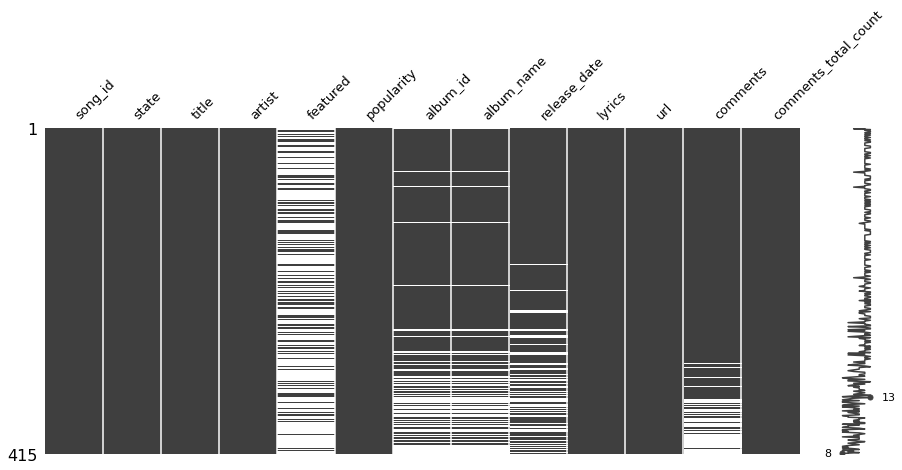

In [ ]:
msno.matrix(data_df.sort_values('popularity', ascending=True), 
            figsize=(15,6), 
            fontsize=13)
plt.show()

---

# 6. Contractions and dash/hyphen words analysis <a name="6-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

The information collected in this section will be used in the following notebook for the further analysis of the lyrics.

## 6.1 Contractions <a name="61-bullet"></a>
Inspecting how many words in the corpus are contractions and what are the most common in Eminem's songs. Later, for simplicity, those words are stored in a text file and expanded by hand. In the following notebook, the file with the expanded contractions is loaded as a dictionary object and used to expand words in other processing steps. However, some contractions can be expanded differently depending on the context, but again, for simplicity, the dictionary returns only one result. 

In [ ]:
# get only Eminem's verses
em_verses = data_df.apply(get_only_eminems_verses, axis=1)

# split verses into words
all_words_raw = em_verses.apply(split_lyrics_into_words)
all_words_raw = np.concatenate(all_words_raw)

In [ ]:
# calculate the count for each contraction in the corpus
contractions_count = defaultdict(lambda: 0)
for word in all_words_raw:
    if "'" in word:
        contractions_count[word] += 1


# most common contractions in Eminem's songs
contractions_df = pd.DataFrame(contractions_count.items(), columns=['contraction', 'count']) \
                    .sort_values('count', ascending=False) \
                    .reset_index(drop=True)[:30]
contractions_df[:30]

,contraction,count
0,i'm,3603
1,don't,1592
2,it's,1353
3,'cause,953
4,ain't,843
5,you're,831
6,'em,599
7,that's,582
8,fuckin',520
9,can't,490


### a) Store the contractions

In [ ]:
CONTRACTIONS_FILE_DIR = settings['CONTRACTIONS_TABLE_PATH']

SAVE_CONTRATIONS = False                 # contractions stored before will be erased
if SAVE_CONTRATIONS:
    np.savetxt(CONTRACTIONS_FILE_DIR, contractions_df[:120][0].values, fmt='%s')

### b) Load the contractions as a dictionary
After manually expanding stored contractions (including "cause","wanna", "gonna" and "gotta" too), in the same text file where they were previously stored.

In [ ]:
CONTRACTIONS_TABLE_PATH = settings['CONTRACTIONS_TABLE_PATH']

# load a text file and convert it to a dictionary
contractions = {}
with open(CONTRACTIONS_TABLE_PATH) as f:   
    for line in f:
        (key, val) = line.split(':')
        contractions[key] = val.strip()
        
# show the contractions
pd.DataFrame(contractions.items(), columns=["contraction", "expanded"])

,contraction,expanded
0,i'm,i am
1,don't,do not
2,it's,it is
3,'cause,because
4,cause,because
...,...,...
118,usin',using
119,we'd,we had
120,lil',little
121,he'd,he had


## 6.2 Dash/hyphen words <a name="62-bullet"></a>
In accordance with this results and additional inspection as well, the `edit_dash_words` function is defined in the following notebook and used to modify and filter out lyrics from the words with dash characters.

In [ ]:
# calculate the count of each dash word in the corpus
dash_words_count = defaultdict(lambda: 0)
for word in all_words_raw:
    if "-" in word:
        dash_words_count[word] += 1

dash_words_df = pd.DataFrame(dash_words_count.items(), columns=['dash words', 'count']) \
                  .sort_values('count', ascending=False)   \
                  .reset_index(drop=True)

# most common dash/hyphen words in Eminem's songs
dash_words_df[:30]

,dash words,count
0,hip-hop,39
1,ha-ha,37
2,-,31
3,oh-oh,31
4,uh-huh,24
5,wee-wee,20
6,chka-chka,17
7,g-unit,14
8,twenty-five,12
9,uh-uh,12


---

# 7. Store the dataset after processing <a name="7-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

### a) store the dataset for the EDA notebook (#3)

In [ ]:
STORE_DATA = False
EMINEM_DF_CLEAN_PATH = settings['EMINEM_DF_ALL_CLEAN_PATH']               # or 'EMINEM_DF_SONGS_CLEAN_PATH'

if STORE_DATA:
    with open(EMINEM_DF_CLEAN_PATH, 'wb') as handle:
        pickle.dump(data_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

### b) store the dataset for the lyrics generation notebooks (#4a & #4b)

In [ ]:
STORE_DATA = False
EMINEM_LYRICS_DF_PATH = settings['LYRICS_DF_ALL_PATH']         # or 'LYRICS_DF_SONGS_PATH'

if STORE_DATA:
    with open(EMINEM_LYRICS_DF_PATH, 'wb') as handle:
        pickle.dump(data_df[['title', 'lyrics']], handle, protocol=pickle.HIGHEST_PROTOCOL)